In [ ]:
import pandas as pd
import numpy as np
import timestamp
import scipy.signal as sp_signal
import re
import glob
from scipy.fftpack import fft
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from serial import Serial
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt

In [2]:
eeg = pd.read_csv('data/EEG_run-1.csv')
target = pd.read_csv('move/move1_log.csv')
eeg = eeg.drop(columns=['EEG_Channel_4','EEG_Channel_5','EEG_Channel_6','EEG_Channel_7'])
eeg.head()

,EEG_Channel_0,EEG_Channel_1,EEG_Channel_2,EEG_Channel_3
0,0.000000,0.000000,0.000000,0.000000
1,-15388.527857,3344.022136,3426.924756,2259.448440
2,-15410.387863,3317.691781,3408.037532,2236.023812
3,-15422.636619,3311.321534,3396.258163,2231.464056
4,-15406.297494,3332.131008,3410.004486,2251.938254


In [3]:
target.head()

,timestamp,event,speed
0,2025-03-12 15:26:51,right,18
1,2025-03-12 15:26:54,blink,0
2,2025-03-12 15:26:55,right,15
3,2025-03-12 15:26:59,blink,0
4,2025-03-12 15:27:00,right,17


In [4]:
def extract_number(filename):
    """Extracts the number from filenames like EEG_run-1.csv or move1_log.csv"""
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

eeg_files = sorted(glob.glob("data/EEG_run-*.csv"), key=extract_number)
move_files = sorted(glob.glob("move/move*_log.csv"), key=extract_number)

all_runs = []

for eeg_file, move_file in zip(eeg_files, move_files):
    print(f"Processing EEG file: {eeg_file} with Movement log: {move_file}")

    eeg_df = pd.read_csv(eeg_file)
    move_df = pd.read_csv(move_file)

    # Convert movement log timestamps to datetime
    move_df['timestamp'] = pd.to_datetime(move_df['timestamp'])

    # Align EEG start time with movement events
    # Given that the ball starts moving at 18.44s and EEG recording begins at 13s,
    # the offset is 5.44 seconds.
    offset = pd.Timedelta(seconds=5.44)
    start_time_eeg = move_df['timestamp'].min() - offset

    # Generate timestamps for EEG samples (250 Hz sampling rate)
    n_samples = len(eeg_df)
    sample_interval = 1 / 250
    time_deltas = pd.to_timedelta(np.arange(n_samples) * sample_interval, unit='s')
    eeg_df['timestamp'] = start_time_eeg + time_deltas

    # Create a 'ms' column: time in milliseconds from the start of the run
    eeg_df['ms'] = (eeg_df['timestamp'] - eeg_df['timestamp'].iloc[0]).dt.total_seconds() * 1000

    # Initialize event and speed columns
    eeg_df['event'] = 'none'
    eeg_df['speed'] = 0

    # Each movement event lasts 1 second. Create an end_time column.
    move_df['end_time'] = move_df['timestamp'] + pd.Timedelta(seconds=1)

    # Loop over each movement event to label EEG samples
    for idx, move in move_df.iterrows():
        mask = (eeg_df['timestamp'] >= move['timestamp']) & (eeg_df['timestamp'] < move['end_time'])
        eeg_df.loc[mask, 'event'] = move['event']
        eeg_df.loc[mask, 'speed'] = move['speed']

    # Append processed run to list
    all_runs.append(eeg_df)

merged_all_df = pd.concat(all_runs, ignore_index=True)
merged_all_df.to_csv('merged_all_runs.csv', index=False)
print("All 9 runs merged and saved to merged_all_runs.csv")


Processing EEG file: data\EEG_run-1.csv with Movement log: move\move1_log.csv
Processing EEG file: data\EEG_run-2.csv with Movement log: move\move2_log.csv
Processing EEG file: data\EEG_run-3.csv with Movement log: move\move3_log.csv
Processing EEG file: data\EEG_run-4.csv with Movement log: move\move4_log.csv
Processing EEG file: data\EEG_run-5.csv with Movement log: move\move5_log.csv
Processing EEG file: data\EEG_run-6.csv with Movement log: move\move6_log.csv
Processing EEG file: data\EEG_run-7.csv with Movement log: move\move7_log.csv
Processing EEG file: data\EEG_run-8.csv with Movement log: move\move8_log.csv
Processing EEG file: data\EEG_run-9.csv with Movement log: move\move9_log.csv
All 9 runs merged and saved to merged_all_runs.csv


In [5]:
eeg_files = sorted(glob.glob("rundata/EEG_run-*.csv"), key=extract_number)
move_files = sorted(glob.glob("rundata//move*_log.csv"), key=extract_number)

all_runs = []

for eeg_file, move_file in zip(eeg_files, move_files):
    print(f"Processing EEG file: {eeg_file} with Movement log: {move_file}")

    eeg_df = pd.read_csv(eeg_file)
    move_df = pd.read_csv(move_file)

    # Convert movement log timestamps to datetime
    move_df['timestamp'] = pd.to_datetime(move_df['timestamp'])

    # Align EEG start time with movement events
    # Given that the ball starts moving at 18.44s and EEG recording begins at 13s,
    # the offset is 5.44 seconds.
    offset = pd.Timedelta(seconds=5.44)
    start_time_eeg = move_df['timestamp'].min() - offset

    # Generate timestamps for EEG samples (250 Hz sampling rate)
    n_samples = len(eeg_df)
    sample_interval = 1 / 250
    time_deltas = pd.to_timedelta(np.arange(n_samples) * sample_interval, unit='s')
    eeg_df['timestamp'] = start_time_eeg + time_deltas

    # Create a 'ms' column: time in milliseconds from the start of the run
    eeg_df['ms'] = (eeg_df['timestamp'] - eeg_df['timestamp'].iloc[0]).dt.total_seconds() * 1000

    # Initialize event and speed columns
    eeg_df['event'] = 'none'
    eeg_df['speed'] = 0

    # Each movement event lasts 1 second. Create an end_time column.
    move_df['end_time'] = move_df['timestamp'] + pd.Timedelta(seconds=1)

    # Loop over each movement event to label EEG samples
    for idx, move in move_df.iterrows():
        mask = (eeg_df['timestamp'] >= move['timestamp']) & (eeg_df['timestamp'] < move['end_time'])
        eeg_df.loc[mask, 'event'] = move['event']
        eeg_df.loc[mask, 'speed'] = move['speed']

    # Append processed run to list
    all_runs.append(eeg_df)

merged_all_df = pd.concat(all_runs, ignore_index=True)
merged_all_df.to_csv('run.csv', index=False)
print("All 2 runs merged and saved to merged_all_runs.csv")

Processing EEG file: rundata\EEG_run-10.csv with Movement log: rundata\move10_log.csv
All 2 runs merged and saved to merged_all_runs.csv


In [ ]:
df.head()

,EEG_Channel_0,EEG_Channel_1,EEG_Channel_2,EEG_Channel_3,EEG_Channel_4,EEG_Channel_5,EEG_Channel_6,EEG_Channel_7,timestamp,ms,event,speed
0,9.955740,0.581279,-0.289046,0.826121,90.927448,90.927448,90.927448,90.927448,2025-03-12 15:26:45.560,0.0,none,0
1,-7984.100324,1725.751352,1769.303966,1165.041996,-97192.320671,-97192.320671,-97192.320671,-97192.320671,2025-03-12 15:26:45.564,4.0,none,0
2,-13971.769866,3018.065702,3094.749370,2037.240974,-170057.242021,-170057.242021,-170057.242021,-170057.242021,2025-03-12 15:26:45.568,8.0,none,0
3,-16907.566476,3651.990176,3744.586259,2465.191219,-205780.773272,-205780.773272,-205780.773272,-205780.773272,2025-03-12 15:26:45.572,12.0,none,0
4,-17082.601754,3690.332040,3783.158604,2491.138026,-207907.429150,-207907.429150,-207907.429150,-207907.429150,2025-03-12 15:26:45.576,16.0,none,0


In [21]:
# Load dataset
file_path = "merged_df.csv"
df = pd.read_csv(file_path)
print("[INFO] Dataset loaded successfully.")

# Ensure timestamp is a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Identify EEG channels
df = df.drop(columns = ['EEG_Channel_4','EEG_Channel_5','EEG_Channel_6','EEG_Channel_7'])
eeg_channels = [col for col in df.columns if "EEG_Channel" in col]

# Filtering functions
def bandpass_filter(data, lowcut=0.5, highcut=35, fs=250, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sp_signal.butter(order, [low, high], btype='band')
    return sp_signal.filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=250, Q=30):
    b, a = sp_signal.iirnotch(freq / (fs/2), Q)
    return sp_signal.filtfilt(b, a, data)

# Apply filtering to EEG channels using DataFrame.apply for potential speed improvements
df[eeg_channels] = df[eeg_channels].apply(
    lambda col: notch_filter(bandpass_filter(col.values, fs=250), freq=50, fs=250, Q=30)
)
print("[INFO] Applied filtering to EEG data.")

# Improved Feature Extraction: using bandpower features via Welch's method
def extract_features(df, eeg_channels, fs=250, rolling_window=5):
    feature_df = pd.DataFrame(index=df.index)

    # Rolling mean features (local average)
    for ch in eeg_channels:
        feature_df[f'RM_{ch}'] = df[ch].rolling(window=rolling_window).mean()
    
    # Bandpower features using Welch's method
    # Frequency bands commonly used in EEG: delta, theta, alpha, beta
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}
    for ch in eeg_channels:
        # Use nperseg as the smaller of 256 or length of the channel data
        freqs, psd = sp_signal.welch(df[ch].values, fs=fs, nperseg=min(256, len(df)))
        for band, (low, high) in bands.items():
            mask = (freqs >= low) & (freqs < high)
            # Compute power by integrating the PSD over the frequency band using np.trapezoid
            band_power = np.trapezoid(psd[mask], freqs[mask])
            # Replicate the bandpower value across all rows (constant feature per channel)
            feature_df[f'{ch}_{band}_power'] = band_power

    # Gradient features (to capture local changes)
    for ch in eeg_channels:
        feature_df[f'Grad_{ch}'] = np.gradient(df[ch].values)

    # Include behavioral features
    feature_df["speed"] = df["speed"]
    feature_df["event"] = df["event"]

    return feature_df.dropna()

df_features = extract_features(df, eeg_channels)
print("[INFO] Extracted features.")

# Encode event labels
label_encoder = LabelEncoder()
df_features["event"] = label_encoder.fit_transform(df_features["event"])
joblib.dump(label_encoder, "label_encoder_windows.pkl")

# Prepare data and split into train-test sets
X = df_features.drop(columns=["event"])
y = df_features["event"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("[INFO] Data split.")

# Create a pipeline that standardizes data and fits an XGBoost classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# Hyperparameter tuning using RandomizedSearchCV for XGBoost
param_dist = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.5, 0.7, 1.0],
    'clf__colsample_bytree': [0.5, 0.7, 1.0],
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
joblib.dump(best_model, "xgb_windows_model.pkl")

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n Best Tuned XGBoost Training Accuracy: {train_acc:.2f}")
print(f" Best Tuned XGBoost Testing Accuracy: {test_acc:.2f}")

# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


[INFO] Dataset loaded successfully.
[INFO] Applied filtering to EEG data.
[INFO] Extracted features.
[INFO] Data split.
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Drago\anaconda3\envs\CondaEnv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:38:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Best Tuned XGBoost Training Accuracy: 0.84
 Best Tuned XGBoost Testing Accuracy: 0.78

 Classification Report:
              precision    recall  f1-score   support

       blink       0.82      0.06      0.11      3733
        down       0.54      0.54      0.54      4233
        left       0.58      0.55      0.56      4325
        none       0.89      1.00      0.94     29308
       right       0.56      0.55      0.55      4425
          up       0.55      0.60      0.57      4455

    accuracy                           0.78     50479
   macro avg       0.66      0.55      0.55     50479
weighted avg       0.77      0.78      0.75     50479



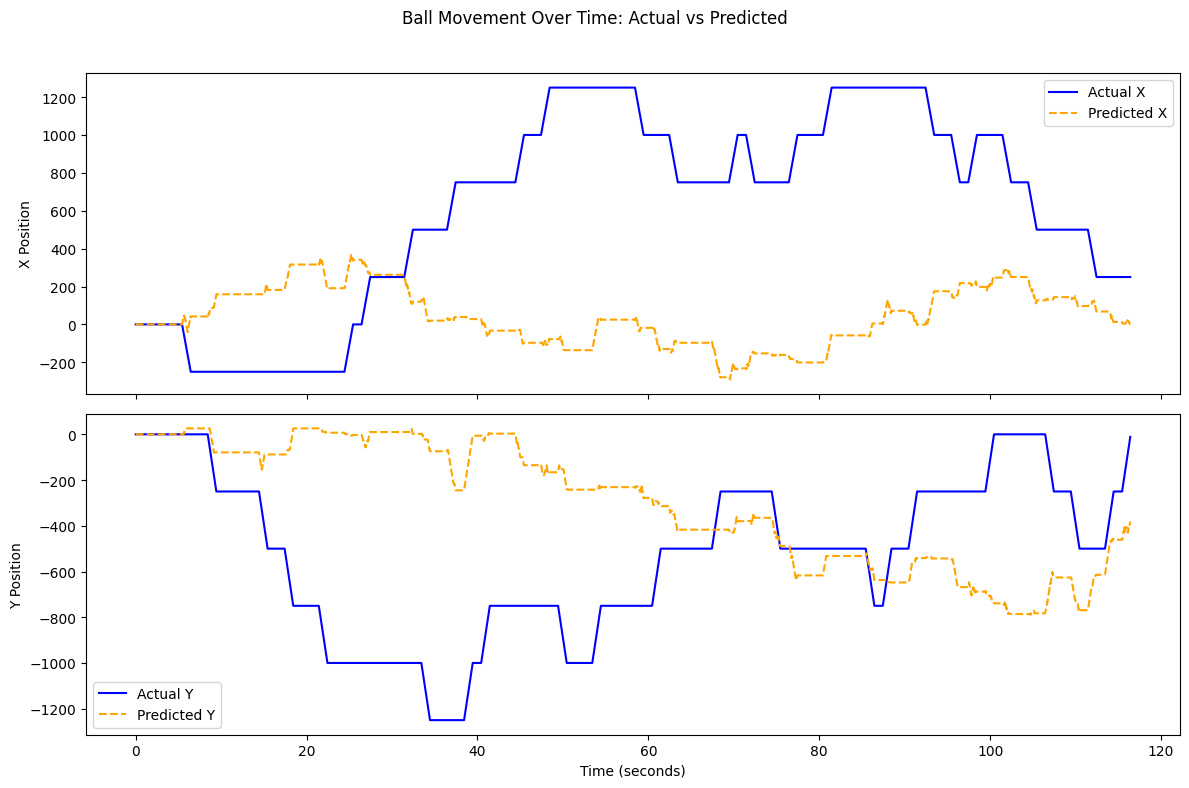

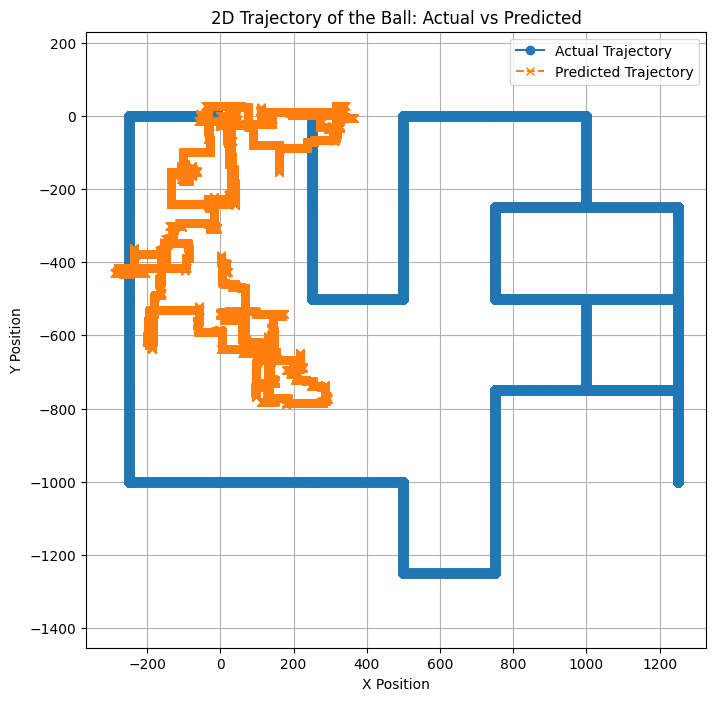

In [22]:
def bandpass_filter(data, lowcut=0.5, highcut=35, fs=250, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sp_signal.butter(order, [low, high], btype='band')
    return sp_signal.filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=250, Q=30):
    b, a = sp_signal.iirnotch(freq / (fs/2), Q)
    return sp_signal.filtfilt(b, a, data)

def extract_features(df, eeg_channels, fs=250, rolling_window=5):
    feature_df = pd.DataFrame(index=df.index)
    
    # Rolling Mean features (for each channel)
    for ch in eeg_channels:
        feature_df[f'RM_{ch}'] = df[ch].rolling(window=rolling_window).mean()
    
    # Bandpower features using Welch’s method in standard EEG bands
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}
    for ch in eeg_channels:
        # Use nperseg as the smaller of 256 or length of the data
        freqs, psd = sp_signal.welch(df[ch].values, fs=fs, nperseg=min(256, len(df)))
        for band, (low, high) in bands.items():
            mask = (freqs >= low) & (freqs < high)
            band_power = np.trapezoid(psd[mask], freqs[mask])
            feature_df[f'{ch}_{band}_power'] = band_power
    
    # Gradient features to capture local change
    for ch in eeg_channels:
        feature_df[f'Grad_{ch}'] = np.gradient(df[ch].values)
    
    # Include other features if used in training (e.g., speed)
    if 'speed' in df.columns:
        feature_df['speed'] = df['speed']
    
    # Drop any rows with missing values (e.g., from rolling window calculation)
    feature_df.dropna(inplace=True)
    return feature_df

# Load run.csv (update the path as needed)
df_run = pd.read_csv('run.csv')
df_run['timestamp'] = pd.to_datetime(df_run['timestamp'])
# Create a seconds-from-start column for time-based plots
df_run['time_seconds'] = (df_run['timestamp'] - df_run['timestamp'].iloc[0]).dt.total_seconds()

# Identify EEG channels (here, we use all EEG channels from the CSV)
eeg_channels = [col for col in df_run.columns if col.startswith('EEG_Channel')]

# Apply filtering to all EEG channels
df_run[eeg_channels] = df_run[eeg_channels].apply(
    lambda col: notch_filter(bandpass_filter(col.values, fs=250), freq=50, fs=250, Q=30)
)

df_run_features = extract_features(df_run, eeg_channels)
valid_indices = df_run_features.index

best_model = joblib.load("best_xgb_windows_model.pkl")
label_encoder = joblib.load("label_encoder_windows.pkl")

y_run_pred = best_model.predict(df_run_features)
predicted_events = label_encoder.inverse_transform(y_run_pred)
df_run.loc[valid_indices, 'predicted_event'] = predicted_events


# Define a mapping from event to movement increments (adjust as desired)
movement_dict = {
    'left':  (-1,  0),
    'right': ( 1,  0),
    'up':    ( 0,  1),
    'down':  ( 0, -1),
    'blink': ( 0,  0),
    'none':  ( 0,  0)
}

def compute_trajectory(events):
    x, y = 0, 0
    xs, ys = [], []
    for ev in events:
        dx, dy = movement_dict.get(ev, (0, 0))
        x += dx
        y += dy
        xs.append(x)
        ys.append(y)
    return xs, ys

# Get ground truth events from the valid rows (assumes the CSV 'event' column has ground truth)
actual_events = df_run.loc[valid_indices, 'event']
pred_events = df_run.loc[valid_indices, 'predicted_event']

actual_x, actual_y = compute_trajectory(actual_events)
predicted_x, predicted_y = compute_trajectory(pred_events)

# Save trajectories back into df_run for valid indices
df_run.loc[valid_indices, 'actual_x'] = actual_x
df_run.loc[valid_indices, 'actual_y'] = actual_y
df_run.loc[valid_indices, 'predicted_x'] = predicted_x
df_run.loc[valid_indices, 'predicted_y'] = predicted_y

# (a) Time Series Plot for X and Y positions
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# X position vs. time
axs[0].plot(df_run.loc[valid_indices, 'time_seconds'], df_run.loc[valid_indices, 'actual_x'], label='Actual X', color='blue')
axs[0].plot(df_run.loc[valid_indices, 'time_seconds'], df_run.loc[valid_indices, 'predicted_x'], label='Predicted X', color='orange', linestyle='--')
axs[0].set_ylabel('X Position')
axs[0].legend()

# Y position vs. time
axs[1].plot(df_run.loc[valid_indices, 'time_seconds'], df_run.loc[valid_indices, 'actual_y'], label='Actual Y', color='blue')
axs[1].plot(df_run.loc[valid_indices, 'time_seconds'], df_run.loc[valid_indices, 'predicted_y'], label='Predicted Y', color='orange', linestyle='--')
axs[1].set_ylabel('Y Position')
axs[1].set_xlabel('Time (seconds)')
axs[1].legend()

plt.suptitle('Ball Movement Over Time: Actual vs Predicted')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# (b) 2D Trajectory Plot
plt.figure(figsize=(8, 8))
plt.plot(df_run.loc[valid_indices, 'actual_x'], df_run.loc[valid_indices, 'actual_y'], label='Actual Trajectory', marker='o', linestyle='-')
plt.plot(df_run.loc[valid_indices, 'predicted_x'], df_run.loc[valid_indices, 'predicted_y'], label='Predicted Trajectory', marker='x', linestyle='--')
plt.title('2D Trajectory of the Ball: Actual vs Predicted')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

actual_x = np.array(actual_x)
predicted_x = np.array(predicted_x)
actual_y = np.array(actual_y)
predicted_y = np.array(predicted_y)

# Compute Mean Absolute Error (MAE) and RMSE for X and Y positions
mae_x = mean_absolute_error(actual_x, predicted_x)
mae_y = mean_absolute_error(actual_y, predicted_y)
rmse_x = np.sqrt(mean_squared_error(actual_x, predicted_x))
rmse_y = np.sqrt(mean_squared_error(actual_y, predicted_y))

# Compute Euclidean distance error for each point and then average it
euclidean_errors = np.sqrt((predicted_x - actual_x)**2 + (predicted_y - actual_y)**2)
mean_euclidean_error = np.mean(euclidean_errors)

print(f"Mean Absolute Error (X): {mae_x:.2f}")
print(f"Mean Absolute Error (Y): {mae_y:.2f}")
print(f"RMSE (X): {rmse_x:.2f}")
print(f"RMSE (Y): {rmse_y:.2f}")
print(f"Mean Euclidean Distance Error: {mean_euclidean_error:.2f}")

classification_accuracy = accuracy_score(actual_events, pred_events)
print(f"Event Classification Accuracy: {classification_accuracy:.2f}")


Mean Absolute Error (X): 721.61
Mean Absolute Error (Y): 442.31
RMSE (X): 832.59
RMSE (Y): 569.53
Mean Euclidean Distance Error: 931.81
Event Classification Accuracy: 0.67


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import accuracy_score
# import time

# file_path = "merged_df.csv"
# df = pd.read_csv(file_path)

# # Compute horizontal and vertical voltage differences
# df['horizontal_diff'] = df['EEG_Channel_0'] - df['EEG_Channel_2']
# df['vertical_diff']   = df['EEG_Channel_1'] - df['EEG_Channel_3']

# # Select features and target
# X = df[['horizontal_diff', 'vertical_diff']].values
# y = df['event'].values

# # Balance the dataset using SMOTE
# smote = SMOTE(random_state=42)
# X_balanced, y_balanced = smote.fit_resample(X, y)
# print(f"[INFO] Dataset balanced: {len(X_balanced)} samples.")

# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
# print(f"[INFO] Split data: {len(X_train)} training samples, {len(X_test)} testing samples.")

# # Standardize features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# print("[INFO] Standardized feature values.")

# # Define hyperparameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
#     'gamma': ['scale', 'auto']
# }

# # Set up GridSearchCV with progress tracking
# total_combinations = np.prod([len(v) for v in param_grid.values()])

# svm_model = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
# start_time = time.time()
# svm_model.fit(X_train, y_train)
# end_time = time.time()

# # Best model from GridSearch
# best_svm = svm_model.best_estimator_

# # Evaluate the model
# y_train_pred = best_svm.predict(X_train)
# y_test_pred = best_svm.predict(X_test)

# train_acc = accuracy_score(y_train, y_train_pred)
# test_acc = accuracy_score(y_test, y_test_pred)

# print(f"\n[INFO] Hyperparameter tuning completed in {end_time - start_time:.2f} seconds.")
# print(f"Best SVM Model: {best_svm}")
# print(f"SVM Training Accuracy: {train_acc:.2f}")
# print(f"SVM Testing Accuracy: {test_acc:.2f}")